In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, numpy_bytes_to_str, norm_spa_vecs
from nengo_learn_assoc_mem.paths import data_path

In [3]:
nengo.rc.set("progress", "progress_bar", "nengo.utils.progress.TerminalProgressBar")

## Setup

In [4]:
with h5py.File(os.path.join(data_path, "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [36]:
with h5py.File(os.path.join(data_path, "bcm_rec_pos_match_weights.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [5]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [6]:
t_pause = 0.5
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [7]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [8]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

# Compare FAN1 Target and Foil

In [9]:
simi = spa.similarity(np.array(fan1_pair_vecs), foil1_pair_vecs)

In [12]:
max_simi = np.unravel_index(np.argmax(simi), simi.shape)
min_simi = np.unravel_index(np.argmin(simi), simi.shape)

In [13]:
print(np.dot(fan1_pair_vecs[max_simi[0]], foil1_pair_vecs[max_simi[1]]))
print(np.dot(fan1_pair_vecs[min_simi[0]], foil1_pair_vecs[min_simi[1]]))

0.704908338912
-0.576130169323


In [14]:
with nengo.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

Build finished in 0:00:01.                                                                                   


In [25]:
_, max_fan1_acts = tuning_curves(ens, sim, inputs=fan1_pair_vecs[max_simi[0]])

In [26]:
_, max_foil1_acts = tuning_curves(ens, sim, inputs=foil1_pair_vecs[max_simi[1]])

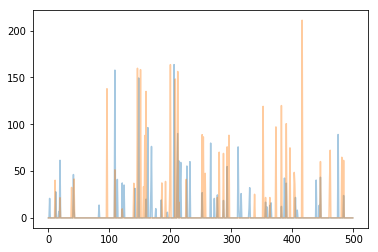

In [27]:
plt.plot(max_fan1_acts, alpha=0.4)
plt.plot(max_foil1_acts, alpha=0.4)

In [28]:
np.dot(max_fan1_acts, max_foil1_acts)

46277.051637531891

In [29]:
_, min_fan1_acts = tuning_curves(ens, sim, inputs=fan1_pair_vecs[min_simi[0]])

In [30]:
_, min_foil1_acts = tuning_curves(ens, sim, inputs=foil1_pair_vecs[min_simi[1]])

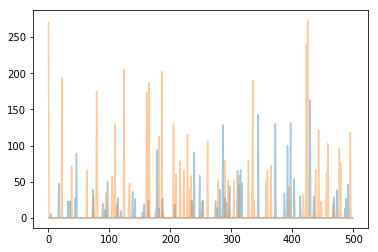

In [31]:
plt.plot(min_fan1_acts, alpha=0.4)
plt.plot(min_foil1_acts, alpha=0.4)

In [32]:
np.dot(min_fan1_acts, min_foil1_acts)

1537.185853295925

In [33]:
min_simi[1]

6

As expected, similar vectors activate similar neurons in a similar manner. However, similarity of activation does not dictate success of decoding. Which somewhat implies the important neurons are already being emphasized and the recurrent weighting does little to change that.

In [37]:
def get_avg_rate(stim_vec, t_sim=1.0, t_start=0.4):
    with nengo.Network(seed=seed) as test_model:
        in_nd = nengo.Node(lambda t: stim_vec)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)

        p_in = nengo.Probe(in_nd, synapse=None)
        p_spikes = nengo.Probe(ens.neurons, synapse=None)
        p_out = nengo.Probe(ens, synapse=0.05)

    with nengo.Simulator(test_model, progress_bar=None) as test_sim:
        test_sim.run(t_sim)
    
    t_sample = t_sim - t_start
    assert t_sample > 0
    td_start = int(t_start / dt)
    base_est = np.sum(test_sim.data[p_spikes][td_start:] > 0, axis=0) / t_sample
    
    td_sample = int(t_sample / dt)
    t_win = td_start + td_sample//2
    begin_est = np.sum(test_sim.data[p_spikes][td_start:t_win] > 0, axis=0) / t_sample / 2
    end_est = np.sum(test_sim.data[p_spikes][t_win:] > 0, axis=0) / t_sample / 2
    
    range_est = np.sort(np.abs(begin_est - end_est))[::-1]
    return {"rate_est": base_est, "est_t_diff": range_est[range_est > 0]}

In [39]:
max_fan1_res = get_avg_rate(fan1_pair_vecs[max_simi[0]])

150897.41840119628

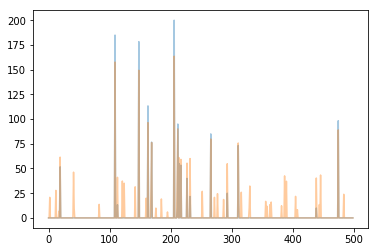

In [45]:
plt.plot(max_fan1_res["rate_est"], alpha=0.4)
plt.plot(max_fan1_acts, alpha=0.4)
np.dot(max_fan1_res["rate_est"], max_fan1_acts)

In [42]:
max_foil1_res = get_avg_rate(foil1_pair_vecs[max_simi[1]])

78143.142032257339

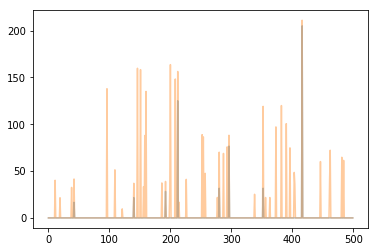

In [44]:
plt.plot(max_foil1_res["rate_est"], alpha=0.4)
plt.plot(max_foil1_acts, alpha=0.4)
np.dot(max_foil1_res["rate_est"], max_foil1_acts)

In [46]:
np.dot(max_foil1_res["rate_est"], max_fan1_res["rate_est"])

11875.0

Technically, the recurrent connections cause similar inputs to diverge and increase sparsity, as expected. But this doesn't tell me how to decrease confidence similarity between outputs. I still can't tell if it has to do with:

- Neg Voja
- Rec BCM distribution

I know that there's a difference between FAN1 and FAN2 output intensity when converged. However, I don't know:

- How this intensity is modified by Neg Voja
- Why this intensity maps onto Foils equally instead of differently.